In [118]:
import sys
import math

sys.path.append('cryoem/')
sys.path.append('cryoem/util')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

import pandas as pd

mpl.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

In [119]:
def read_starfile_angles(path):
    # Read the theoretical starfile
    # We only want (1-indexed): 2 (psi), 3 (phi), 4 (theta)
    # BEWARE skiprows, starfile header lengths may vary
    angles = pd.read_csv(path, delim_whitespace=True, header=None, skiprows=21)
    angles = angles[angles.columns[[1, 2, 3]]]
    angles.columns = [ 'psi', 'phi', 'theta']
    angles = angles.astype(float)
    angles['quaternion'] = angles.apply(lambda row: euler2quat(row.phi*np.pi/180, row.theta*np.pi/180, row.psi*np.pi/180), axis=1)

    return angles

In [120]:
# Euler angles to Quaternion (from https://github.com/asarnow/pyem geom.py)
def euler2quat(alpha, beta, gamma):
    ha, hb, hg = alpha / 2, beta / 2, gamma / 2
    ha_p_hg = ha + hg
    hg_m_ha = hg - ha
    q = [np.cos(ha_p_hg) * np.cos(hb),
                  np.sin(hg_m_ha) * np.sin(hb),
                  np.cos(hg_m_ha) * np.sin(hb),
                  np.sin(ha_p_hg) * np.cos(hb)]
    return q

# Quaternion to Euler Angles (from https://github.com/asarnow/pyem geom.py)
def quat2euler(q):
    ha1 = np.arctan2(q[1], q[2])
    ha2 = np.arctan2(q[3], q[0])
    alpha = ha2 - ha1  # np.arctan2(r21/r20)
    beta = 2 * np.arccos(np.sqrt(q[0]**2 + q[3]**2))  # np.arccos*r33
    gamma = ha1 + ha2  # np.arctan2(r12/-r02)
    return float(alpha*(180/np.pi)), float(beta*(180/np.pi)), float(gamma*(180/np.pi))

# Angular distance between two quaternions
def quatDist(a,b):
    # Check to verify that quaternions are unit lengths
    assert abs(math.sqrt(a[0]**2+a[1]**2+a[2]**2+a[3]**2)-1)<.001,"a is not a unit quaternion"
    assert abs(math.sqrt(b[0]**2+b[1]**2+b[2]**2+b[3]**2)-1)<.001,"b is not a unit quaternion"
    
    # Compute distance
    s = a[0]*b[0] + a[1]*b[1] + a[2]*b[2] + a[3]*b[3]
    s = 2*(s**2)-1
    return np.arccos(s)*180/np.pi

def quatMult(a, b):
    w0, x0, y0, z0 = a
    w1, x1, y1, z1 = b
    return [-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0]

def quatInv(a):
    denom = a[0]**2 + a[1]**2 + a[2]**2 + a[3]**2
    return [a[0]/denom, -1*a[1]/denom, -1*a[2]/denom, -1*a[3]/denom]

def quatMag(a):
    return np.sqrt(a[0]**2 + a[1]**2 + a[2]**2 + a[3]**2)

def quat2aa(q):
    theta = 2*np.arccos(q[0])
    x = q[1]/np.sqrt(1-q[0]**2)
    y = q[2]/np.sqrt(1-q[0]**2)
    z = q[3]/np.sqrt(1-q[0]**2)
    return theta, [x,y,z]

In [121]:
def computePerturbedAngle(q1, theta):
    # pick the angular error distance to apply to this particle
#     d = abs(np.random.normal(0, sigma_angle ,1))
    d = theta
    
    # the first component dq_0 is given by the following:
    dq0 = np.sqrt((1+np.cos(d*(np.pi/180)))/2)

    # the components dq_1,2,3 are given in terms of two random numbers on [0,1] u_1 and u_2:
    u1 = np.random.uniform(0,1,1)
    u2 = np.random.uniform(0,1,1)

    dq1 = z = 2*u1 - 1
    dq2 = np.sqrt(1-z**2)*np.cos(2*np.pi*u2)
    dq3 = np.sqrt(1-z**2)*np.sin(2*np.pi*u2)

    norm = np.sqrt((1-np.cos(d*(np.pi/180)))/2)

    dq1 = dq1*norm
    dq2 = dq2*norm
    dq3 = dq3*norm

    dq = [dq0, dq1, dq2, dq3]

#     qx = quatMult(quatMult(dq,q1),quatInv(dq))

    return quatMult(dq,q1)

In [127]:
print('Reading starfile...')

data = read_starfile_angles('../output/test.star')

print('Read %d particles.' % len(data))
theta = 15
perturbedAngles = [computePerturbedAngle(i,theta) for i in data.quaternion.tolist()]

print('Computed perturbed angles with %d degree fixed distance.' % theta)

eulerAngles = [quat2euler(i) for i in perturbedAngles]

eulerTest = [1, 2, 3]
q = euler2quat(1*(np.pi/180), 2*(np.pi/180), 3*(np.pi/180))
quat2euler(q)

# Euler angles from quat2euler are in order: phi, theta, psi
# Need to write the output in order: psi, phi, theta

# should just import all columns in starfile and replace relevant values


Reading starfile...
Read 100 particles.
Computed perturbed angles with 15 degree fixed distance.


(0.9999999999999994, 1.9999999999998004, 3.0)

In [114]:
data

,psi,phi,theta,quaternion
0,174.653594,-73.865725,75.173300,"[0.5051796660787111, 0.5041292480876016, -0.34..."
1,211.766085,85.969695,62.860298,"[-0.7303854816438329, 0.46420172376590646, 0.2..."
2,93.404180,146.426510,162.428594,"[-0.07617409907159692, -0.44113470207775896, 0..."
3,53.582838,-80.476710,146.043555,"[0.28400300248943383, 0.8805794761090461, 0.37..."
4,119.297272,-68.536943,143.186642,"[0.2852837015878262, 0.9466226519620111, -0.06..."
...,...,...,...,...
95,243.838176,-139.574600,93.077271,"[0.4222442576691153, -0.14727004265018878, -0...."
96,39.383186,-153.708538,58.454117,"[0.4732219518564971, 0.4850887683153529, -0.05..."
97,102.509621,-154.151560,76.029800,"[0.7091911598288351, 0.48311352266936436, -0.3..."
98,71.429721,-54.754929,61.533395,"[0.8501761904626499, 0.45616223753241214, 0.23..."


<IPython.core.display.Javascript object>


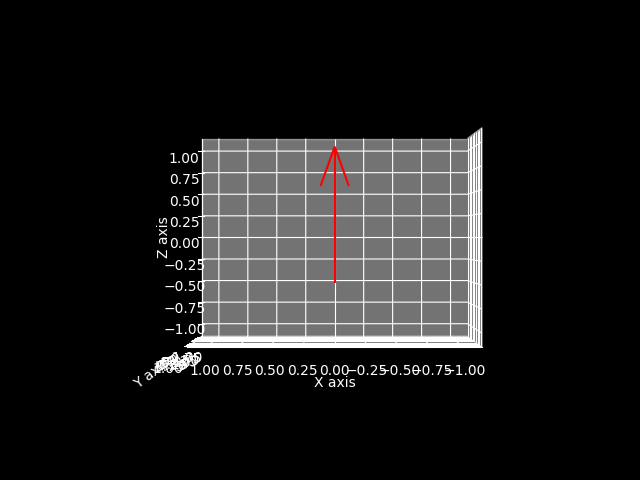

In [23]:

# Initial Euler angles (example)
psi = 90 *(np.pi/180)
rot = 0 *(np.pi/180)
tilt = 0 *(np.pi/180)
# calculate the quaternion of the theoretical orientation from the euler angles
q1 = euler2quat(psi, rot, tilt)


qxs = []
for i in range(250):
    qx = perturbQuat(q1,180)
    qxs.append(quat2aa(qx)[1])
#     print(quatDist(q1,qx))

v = qxs

X = [float(i[0]) for i in v]
Y = [float(i[1]) for i in v]
Z = [float(i[2]) for i in v]

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_zlim([-1.1, 1.1])
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


# ax.quiver(X,Y,Z,X,Y,Z,length=.25,pivot='tip', arrow_length_ratio = .4, normalize=True,linewidths=.75)
ax.quiver(quat2aa(q1)[1][0],quat2aa(q1)[1][1],quat2aa(q1)[1][2],quat2aa(q1)[1][0],quat2aa(q1)[1][1],quat2aa(q1)[1][2],length=1.5,pivot='tip',color='r')

ax.view_init(elev=0, azim=90)
fig.savefig("0.png")


In [14]:
v

[[array([-0.04168159]), array([0.79792128]), array([0.60131879])],
 [array([-0.07411669]), array([0.94648546]), array([0.31412098])],
 [array([-0.48446442]), array([0.11274003]), array([0.86751594])],
 [array([0.87241192]), array([-0.21611046]), array([0.43839903])],
 [array([-0.65729544]), array([0.70445771]), array([0.26777236])],
 [array([-0.07779919]), array([0.7865415]), array([0.61261714])],
 [array([0.68732498]), array([-0.69175771]), array([0.22148509])],
 [array([-0.67977413]), array([0.54748195]), array([0.4880273])],
 [array([0.47688791]), array([-0.23358225]), array([0.84735899])],
 [array([-0.07441348]), array([-0.4918494]), array([0.86749455])],
 [array([0.64543713]), array([0.5304512]), array([0.54957477])],
 [array([0.26168074]), array([-0.52851323]), array([0.80758712])],
 [array([-0.04843821]), array([0.60802784]), array([0.79243668])],
 [array([0.5318796]), array([0.76278744]), array([0.36777631])],
 [array([-0.72619342]), array([0.63123807]), array([0.27236303])],
 

In [25]:
quat2aa(q1)

(1.5707963267948966, [-0.0, 0.0, 1.0])